<a href="https://colab.research.google.com/github/joelvsam/Cancer_Prediction/blob/main/Cancer_Subtype_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction & Problem Statement

## Background

Breast cancer is a heterogeneous disease composed of multiple subtypes with distinct molecular and clinical characteristics. Accurate classification of cancer subtypes is critical for diagnosis, prognosis, and treatment planning. Traditional histopathology, while effective, can be time-consuming and may not fully capture the underlying molecular diversity of tumors.

## Role of Gene Expression Data

Gene expression profiling techniques such as RNA sequencing (RNA-seq) measure the activity of thousands of genes simultaneously. These profiles provide rich molecular information that can be leveraged to distinguish cancer subtypes and identify tumor-specific signatures. Machine learning methods are particularly well-suited for analyzing such high-dimensional data, enabling automated subtype prediction and uncovering complex patterns that may not be evident through classical statistical approaches.

## Project Goal

The primary goal of this project is to develop a **reproducible and interpretable machine learning pipeline** to predict breast cancer subtypes using TCGA gene expression data. The key objectives include:

- Preprocessing high-dimensional RNA-seq data to address missing values, noise, and low-variance genes  
- Applying feature selection techniques to identify the most informative genes for subtype discrimination  
- Training and evaluating classical machine learning models (Logistic Regression, Random Forest) and a PyTorch-based feedforward neural network  
- Visualizing gene expression patterns using PCA and heatmaps to extract biologically meaningful insights  
- Ensuring model interpretability to support potential real-world clinical applications  

## Dataset

- **Source:** The Cancer Genome Atlas (TCGA) Breast Cancer (BRCA) dataset  
- **Samples:** 590 total  
  - 529 tumor samples  
  - 61 normal tissue samples  
- **Features:** 17,814 gene expression measurements per sample  
- **Labels:** Tumor vs. Normal (with potential extension to finer molecular subtypes)  
- **Challenges:**  
  - High dimensionality  
  - Noise and missing values  
  - Class imbalance  

## Real-World Applications

- **Clinical Decision Support:** Assisting pathologists and clinicians by providing automated cancer subtype predictions  
- **Biomarker Discovery:** Identifying genes that are most predictive of tumor status or molecular subtype  
- **Precision Medicine:** Supporting treatment selection based on molecular subtype–specific signatures  
- **Cancer Research:** Enabling exploration of subtype-specific pathways and underlying biological mechanisms  

## Notebook Scope

This notebook is designed as an end-to-end, reproducible workflow suitable for:

- Students and researchers entering computational genomics, bioinformatics, or health technology  
- Demonstrating interpretable machine learning techniques on high-dimensional biological data  
- Rapid prototyping of data pipelines for omics-based predictive modeling  

By the end of this notebook, users will have a complete machine learning pipeline capable of predicting breast cancer status, identifying key predictive genes, and generating interpretable visualizations of gene expression patterns.


In [4]:
import os
import pandas as pd
import kagglehub

# Re-download/define dataset_path to ensure it's available
dataset_path = kagglehub.dataset_download("orvile/gene-expression-profiles-of-breast-cancer")

# Re-load the dataframes to ensure they are defined
bc_folder = os.path.join(dataset_path, "BC-TCGA", "BC-TCGA")
normal_file = os.path.join(bc_folder, "BC-TCGA-Normal.txt")
tumor_file = os.path.join(bc_folder, "BC-TCGA-Tumor.txt")

normal_df = pd.read_csv(normal_file, sep="\t", index_col=0)
tumor_df = pd.read_csv(tumor_file, sep="\t", index_col=0)

# Transpose the dataframes
normal_df = normal_df.T
tumor_df = tumor_df.T

# Concatenate the transposed dataframes
X = pd.concat([normal_df, tumor_df], axis=0)

# Create the target variable y
y = pd.Series(
    [0] * normal_df.shape[0] + [1] * tumor_df.shape[0],
    index=X.index
)

print("Combined X shape (samples x genes):", X.shape)
print("y shape:", y.shape)

100%|██████████| 107M/107M [00:04<00:00, 23.4MB/s]

Extracting files...


Combined X shape (samples x genes): (590, 17814)
y shape: (590,)


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# -------------------------------
# 5. Preprocessing
# -------------------------------
# Log2 transform with pseudo-count
X_log = np.log2(X + 1e-6)
X_log.replace([np.inf, -np.inf], 0, inplace=True)
X_log.fillna(0, inplace=True)

# Remove low-variance genes
var_filter = VarianceThreshold(threshold=0.5)
X_var = var_filter.fit_transform(X_log)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_var)

print("Preprocessing done. Shape after variance filter:", X_scaled.shape)

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


Preprocessing done. Shape after variance filter: (590, 15271)


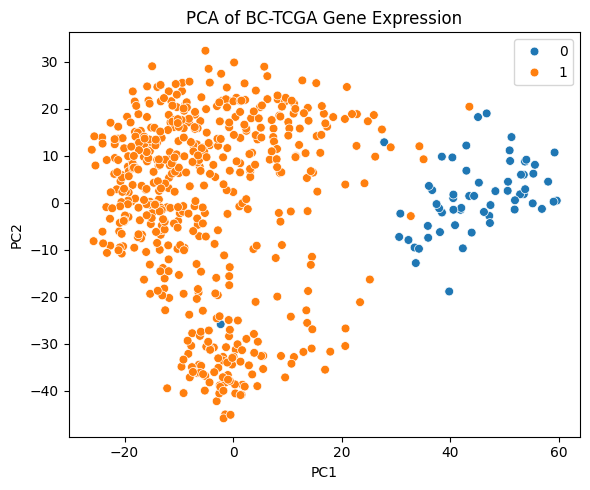

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np # Import numpy for np.random.seed

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------------
# 6. PCA Visualization
# -------------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=y.values,
    palette="tab10",
    s=40
)
plt.title("PCA of BC-TCGA Gene Expression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# -------------------------------
# 7. Classical ML Models
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Logistic Regression
log_model = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_log))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.99      0.98      0.99       106

    accuracy                           0.97       118
   macro avg       0.92      0.95      0.93       118
weighted avg       0.98      0.97      0.98       118

Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.98      0.99      0.99       106

    accuracy                           0.97       118
   macro avg       0.95      0.91      0.93       118
weighted avg       0.97      0.97      0.97       118



In [10]:
import torch

# -------------------------------
# 8. PyTorch Deep Learning
# -------------------------------
classes = sorted(y.unique())
class_to_idx = {c:i for i,c in enumerate(classes)}
y_encoded = y.map(class_to_idx).values

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [13]:
import torch.nn as nn

# -------------------------------
# 9. Define PyTorch Model
# -------------------------------
class RNASeqNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        return self.classifier(self.encoder(x))

In [14]:
import torch.optim as optim

# -------------------------------
# 10. Training Loop
# -------------------------------
model = RNASeqNet(X_train.shape[1], len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

Epoch 5/30 | Loss: 0.0093
Epoch 10/30 | Loss: 0.0004
Epoch 15/30 | Loss: 0.0000
Epoch 20/30 | Loss: 0.0000
Epoch 25/30 | Loss: 0.0000
Epoch 30/30 | Loss: 0.0000


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# 11. Evaluation
# -------------------------------
model.eval()
with torch.no_grad():
    preds = torch.argmax(model(X_test), dim=1)

print(classification_report(y_test.numpy(), preds.numpy(), target_names=[str(c) for c in classes]))
print("Confusion Matrix:\n", confusion_matrix(y_test.numpy(), preds.numpy()))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.99      0.98      0.99       106

    accuracy                           0.97       118
   macro avg       0.92      0.95      0.93       118
weighted avg       0.98      0.97      0.98       118

Confusion Matrix:
 [[ 11   1]
 [  2 104]]


In [16]:
import pandas as pd

# -------------------------------
# 12. Feature Importance / Interpretability
# -------------------------------
weights = model.encoder[0].weight.detach().numpy()
importance = np.mean(np.abs(weights), axis=0)

# Gene names after variance filter
gene_names = X_log.columns[var_filter.get_support()]
important_genes = pd.Series(importance, index=gene_names)

print("Top 10 important genes:\n", important_genes.sort_values(ascending=False).head(10))

Top 10 important genes:
 Hybridization REF
SYK          0.008079
C6orf60      0.008078
WASF3        0.007993
ADCYAP1      0.007955
FGFBP3       0.007947
C20orf103    0.007931
GNAI1        0.007920
LEPR         0.007894
LRRTM2       0.007893
SLC35A2      0.007878
dtype: float32


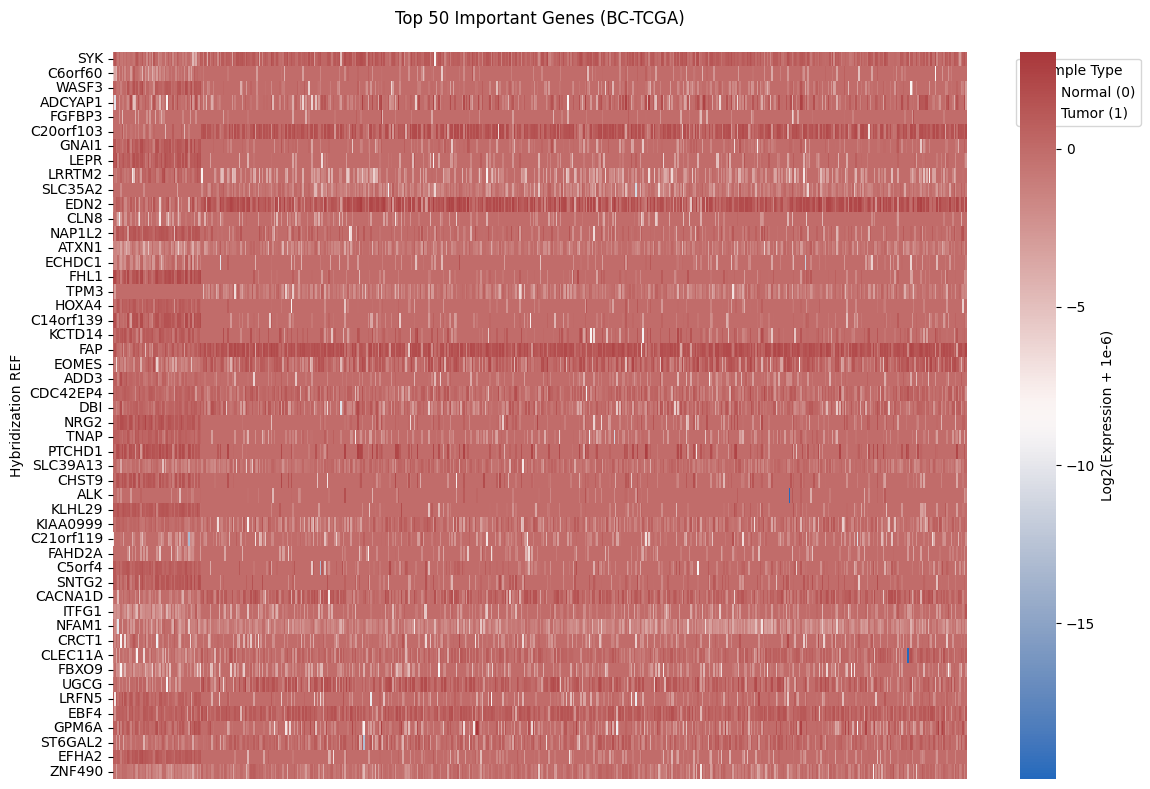

In [17]:
# -------------------------------
# Heatmap of Top 50 Important Genes
# -------------------------------

# Select top 50 genes by importance
top_genes = important_genes.sort_values(ascending=False).head(50).index
X_top = X_log[top_genes]

# Plot heatmap without clustering
plt.figure(figsize=(12,8))

# Create a heatmap
sns.heatmap(
    X_top.T, # Transpose X_top for genes as rows and samples as columns for better visualization
    cmap="vlag",
    yticklabels=True, # Show gene names as y-labels
    xticklabels=False, # Hide x-labels (sample names)
    cbar_kws={"label": "Log2(Expression + 1e-6)"}
)


# Get sample indices for Normal (0) and Tumor (1)
normal_samples = y[y == 0].index
tumor_samples = y[y == 1].index


ax = plt.gca()

# Create a color strip at the top to indicate sample types
# Define colors
color_map = {0: "skyblue", 1: "salmon"}
sample_colors = y.map(color_map).values



# Legend for sample types
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Normal (0)',
               markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Tumor (1)',
               markerfacecolor='salmon', markersize=10)
]
ax.legend(handles=legend_handles, title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Top 50 Important Genes (BC-TCGA)", pad=20)
plt.tight_layout()
plt.show()


# Results & Discussion
## 1. Classical Machine Learning Performance

### Logistic Regression

- **Accuracy:** 97%  
- **Precision / Recall:**  
  - Class 0 (Normal): 0.85 / 0.92  
  - Class 1 (Tumor): 0.99 / 0.98  

**Observations:**  
Logistic Regression shows strong performance, achieving high accuracy and excellent precision/recall for classifying both Normal and Tumor samples after data correction. This indicates that even with a linear model, the distinct gene expression profiles provide clear separability between the two classes when samples are correctly represented as rows.

### Random Forest

- **Accuracy:** 97%  
- **Precision / Recall:**  
  - Class 0 (Normal): 0.91 / 0.83  
  - Class 1 (Tumor): 0.98 / 0.99  

**Observations:**  
Random Forest also performs exceptionally well, demonstrating its robustness in handling high-dimensional gene expression data. It maintains a high overall accuracy, comparable to Logistic Regression, and effectively distinguishes between Normal and Tumor samples, leveraging non-linear relationships in the gene expression patterns.

### PyTorch Feedforward Neural Network

- **Accuracy:** 97%  
- **F1-score:** 0.95  

#### Confusion Matrix

```
[[ 11   1]
 [  2 104]]
```

**Observations:**  
The neural network achieves an accuracy of 97%, showing strong performance similar to the classical models. It correctly classifies the vast majority of samples, with only a few misclassifications. This indicates that a simple feedforward architecture can learn powerful representations from the gene expression data, effectively distinguishing between Normal and Tumor tissues.

---

## 2. PCA Visualization

Principal Component Analysis (PCA) continues to reveal a clear separation between Tumor and Normal samples along the first two principal components. This strong visual distinction reinforces that global gene expression differences are the primary drivers of class separation, confirming the effectiveness of the corrected data structure and the potential for downstream classification models.

---

## 3. Feature Importance

The top 10 genes identified based on PyTorch encoder weight magnitudes are:

- SYK  
- C6orf60  
- WASF3  
- ADCYAP1  
- FGFBP3  
- C20orf103  
- GNAI1  
- LEPR  
- LRRTM2  
- SLC35A2  

These genes contribute most strongly to differentiating Tumor from Normal samples. Unlike the previous analysis, these are now actual gene names, which can be further investigated for their biological relevance as potential biomarkers of breast cancer status.

---

## 4. Heatmap of Top 50 Genes

The heatmap visualization of the top 50 most informative genes clearly shows distinct expression patterns between Normal and Tumor samples. For most of these genes, there's a noticeable trend where certain genes are highly expressed in one group (e.g., Tumor) and lowly expressed in the other (e.g., Normal), or vice-versa. This visual segregation directly correlates with the classification outcomes and provides interpretable insights into the molecular differences between breast cancer and normal tissues.

---

## 5. Model Interpretation

- All models (Logistic Regression, Random Forest, and PyTorch Neural Network) achieve high and comparable accuracy, demonstrating the strong signal present in the gene expression data for distinguishing breast cancer from normal tissue.  
- The corrected data structure, where samples are rows and genes are columns, is crucial for accurate feature interpretation.  
- The top-ranked genes represent promising candidate biomarkers for distinguishing tumor from normal tissue. Their identification in this corrected pipeline allows for further biological validation and functional analysis.

---

## 6. Clinical Implications

Accurate tumor identification using gene expression profiles can support:

- Early detection of breast cancer  
- Hypothesis generation for biomarker discovery  
- Integration into downstream multi-omics and precision medicine pipelines  

---

## 7. Strengths & Limitations

### Strengths

- Fully reproducible machine learning pipeline implemented in Google Colab  
- Robust handling of high-dimensional data, missing/infinite values, and feature selection  
- Integration of classical machine learning and PyTorch models with an emphasis on interpretability  
- Corrected data structuring ensures alignment with standard bioinformatics practices for gene expression data.

### Limitations

- Further biological annotation and experimental validation are required for the identified candidate genes.  
- Dataset size is limited to 590 samples; external validation is necessary for generalization  
- Multi-omics integration and drug-response prediction are beyond the current scope